# import packages

In [ ]:
#indicate here directory where source data is located
DATA_DIR = 

In [1]:
# scanpy packages 
import scanpy as sc
import scanpy.external as sce
import anndata as anndata

# Laughney packages
from anndata import AnnData
import time
import os
import numpy as np
import seaborn as sns
import pandas as pd

from colors import rgb, hex
import scipy.cluster.hierarchy as hc
import scipy as scipy
from scipy.stats import ttest_ind
from scipy.sparse import csr_matrix
import colors as colors

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.font_manager
from matplotlib import rcParams

%matplotlib inline

# other packages
import glob
from collections import OrderedDict
from scipy.sparse import csr_matrix
import scipy.stats
from statistics import median
from statistics import mean
from scanpy.external.pp import magic
from kneed import KneeLocator
import doubletdetection


In [2]:
# define colors

sc.set_figure_params(scanpy=True, dpi=300, dpi_save=300, frameon=False, vector_friendly=True, fontsize=7, figsize=(10,10), color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x')
sns.set_style('white')

color_map_clusters = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
"#FFDBE5", "#7A4900", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
"#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
"#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
"#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
"#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
"#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
"#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
"#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
"#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
"#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
"#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
"#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C"]

godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"]

color_map_bimodal = ['#e1e1e1','#FF4A46']

color_map_clusters_plt = cm = LinearSegmentedColormap.from_list(
        'color_map_clusters', color_map_clusters)

# correlate microarray data with CD56dim signatures

In [95]:
#load data
microarray_raw_df = pd.read_csv(DATA_DIR + 'CIBERSORT_EBI_curated.csv', index_col='Column1')

#load signature from 10.1016/j.immuni.2018.09.009
#NK_sig = ['FGFBP2','GZMB','GZMA','SPON2','S100A4','CST7','FCGR3A','IGFBP7','GZMH','CFL1','ITGB2','CYBA','LGALS1','CD247','LAIR2','PRF1','DSTN','KIR2DL3','PTGDS','GTF3C1','EIF3B','KLRD1','TPM3','CTSD','LCP1','CD164','RBM38','SAR1A','ENC1','ZEB2','TLE1','EMP3','CD99']#CD56dim
#NK_sig = ['FGFBP2','GZMB','GZMA','SPON2','S100A4','CST7','FCGR3A','IGFBP7','GZMH','CFL1','ITGB2']#CD56dim Top10
#NK_sig = ['FGFBP2','GZMB','GZMA','SPON2','S100A4']#CD56dim
#NK_sig = ['GZMK','CD44','PPP1R14B','CXCR3','RPL36A','SCML1','COTL1','NCF1','XCL1','HLA-DRB1','CD83','LTB','ZFP36L2','VIM','CD82','SPOCK2','CMC1','CNN2','PDE4B','IFRD1','RGCC','OCIAD2'] #CD56bright
#NK_sig = ['GZMK','CD44','PPP1R14B','CXCR3','RPL36A'] #CD56bright Top5 this is the final sig
NK_sig = ['NCAM1','NCR1','NCR2','NCR3','KIR3DL1','KIR3DL2','KIR3DL3','KIR2DL1','KIR2DL2','KIR2DL3','KIR2DL4',
          'KIR2DL5A','KIR2DL5B',
          'KIR2DS1','KIR2DS2','KIR2DS3','KIR2DS4','KIR3DS1','KIR3DS2',
         'KIR2DS5',]

#load CIBERSORT output
CIBERSORT_df = pd.read_csv(DATA_DIR + 'CIBERSORT.Output_intensity_based_allsamples.csv', index_col='Input Sample')
patient_id_path = DATA_DIR + 'Timke_PARC_CIBERSORT_ids.csv'
timepoint_color_dict = {8:'#1245D8',24:'#D89312',70:'#D81812'}



patient_color_list = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
"#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
"#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
"#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
"#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
"#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
"#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
"#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
"#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
"#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
"#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
"#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C"]

color_map_timepoints = ['#1245D8', '#D89312', '#D81812']

In [21]:
'A15', 'A30', 'B18', 'A28', 'B19', 'A27', 'B20', 'A25', 'B21', 'A24',
       'B22', 'B32', 'B24', 'B23', 'B28', 'B30', 'A16', 'A17', 'A20', 'A18',
       'B17', 'B27', 'B25', 'B21', 'B20', 'B25', 'B19', 'B28', 'B18', 'B23',
       'B30', 'B27', 'B24', 'B17', 'A32', 'A15', 'A16', 'A17', 'A18', 'A19',
       'A20', 'A23', 'A24', 'A25', 'B32', 'A30', 'A27', 'A28', 'B20', 'B30',
       'A15', 'B28', 'B17', 'A30', 'B27', 'A18', 'B25', 'B18', 'A19', 'B24',
       'A20', 'A28', 'B23', 'A32', 'B22', 'A24', 'B21', 'B19', 'A25', 'A27',
       'A23'

IndentationError: unexpected indent (<ipython-input-21-07c4785727b1>, line 2)

In [96]:
patient_id_df = pd.read_csv(patient_id_path)
patient_id_df = patient_id_df.set_index('CIBERSORT_ID')
patient_id_dict = patient_id_df['timepoint'].to_dict()
patient_id_dict

{'A15': 0,
 'A15_1': 8,
 'A15_2': 24,
 'A15_3': 70,
 'A16': 0,
 'A16_4': 8,
 'A16_5': 24,
 'A17': 0,
 'A17_6': 8,
 'A17_7': 24,
 'A18': 0,
 'A18_10': 70,
 'A18_8': 8,
 'A18_9': 24,
 'A19': 0,
 'A19_11': 24,
 'A19_12': 70,
 'A20': 70,
 'A20_13': 0,
 'A20_14': 8,
 'A20_15': 24,
 'A23': 70,
 'A23_16': 0,
 'A23_17': 24,
 'A24': 70,
 'A24_18': 0,
 'A24_19': 8,
 'A24_20': 24,
 'A25': 70,
 'A25_21': 0,
 'A25_22': 8,
 'A25_23': 24,
 'A27': 70,
 'A27_24': 0,
 'A27_25': 8,
 'A27_26': 24,
 'A28': 70,
 'A28_27': 0,
 'A28_28': 8,
 'A28_29': 24,
 'A30': 70,
 'A30_30': 0,
 'A30_31': 8,
 'A30_32': 24,
 'A32': 0,
 'A32_33': 0,
 'A32_34': 24,
 'A32_35': 70,
 'B17': 0,
 'B17_36': 8,
 'B17_37': 24,
 'B17_38': 70,
 'B18': 0,
 'B18_39': 8,
 'B18_40': 24,
 'B18_41': 70,
 'B19': 0,
 'B19_42': 8,
 'B19_43': 24,
 'B19_44': 70,
 'B20': 0,
 'B20_45': 8,
 'B20_46': 24,
 'B20_47': 70,
 'B21': 0,
 'B21_48': 8,
 'B21_49': 24,
 'B21_50': 70,
 'B22': 0,
 'B22_51': 8,
 'B22_52': 70,
 'B22_53': 0,
 'B23': 8,
 'B23_54': 2

In [97]:
# Filter out genes not present in microarray
marker_T_filtered = []
for marker in NK_sig:
    if marker in microarray_raw_df.index:   
        marker_T_filtered.append(marker)
    else:
        print(marker + ' filtered out')

KIR2DL1 filtered out
KIR2DL3 filtered out
KIR2DL5B filtered out
KIR2DS3 filtered out
KIR3DS1 filtered out
KIR3DS2 filtered out
KIR2DS5 filtered out


In [98]:
#subset dataframe
microarray_raw_df_clean = microarray_raw_df.loc[marker_T_filtered,:]

merged_gene_ls = []

for i in list(set(microarray_raw_df_clean.index)):
    a = np.mean(microarray_raw_df_clean.loc[i,:])
    if a.shape != ():
        merged_gene_ls.append(a)
    else:
        a = np.array(microarray_raw_df_clean.loc[i,:])
        merged_gene_ls.append(a)

merged_gene_np = np.vstack(merged_gene_ls)
merged_gene_df = pd.DataFrame(merged_gene_np, index=list(set(microarray_raw_df_clean.index)),columns=microarray_raw_df_clean.columns)
merged_gene_df

,A15,A15_1,A15_2,A15_3,A16,A16_4,A16_5,A17,A17_6,A17_7,...,B28_65,B28_66,B28_67,B30,B30_68,B30_69,B30_70,B32,B32_71,B32_72
KIR2DL4,773.500000,537.000000,308.500000,367.50,2852.500000,488.00,1091.000000,586.5,956.00,325.90,...,29.200000,19.500000,21.60,326.05,207.200000,220.300000,404.000000,390.000000,191.00,79.80
NCR3,2090.000000,2660.000000,1290.000000,1280.00,2490.000000,2800.00,1700.000000,5210.0,3340.00,2210.00,...,172.000000,83.500000,32.10,2930.00,2610.000000,1320.000000,5910.000000,3150.000000,2250.00,1310.00
KIR2DS1,39.200000,52.400000,18.600000,40.10,127.000000,104.00,107.000000,85.7,63.70,41.50,...,4.000000,1.640000,1.26,44.60,35.700000,23.300000,101.000000,363.000000,167.00,49.50
KIR2DS2,233.000000,230.000000,140.000000,132.00,509.000000,476.00,578.000000,429.0,278.00,206.00,...,16.100000,6.640000,2.60,352.00,177.000000,111.000000,490.000000,1390.000000,825.00,273.00
NCR1,391.000000,410.000000,333.000000,287.00,513.000000,585.00,463.000000,533.0,222.00,275.00,...,38.700000,35.100000,5.58,573.00,269.000000,347.000000,2680.000000,677.000000,535.00,248.00
KIR2DL2,190.000000,176.000000,121.000000,76.30,340.000000,368.00,357.000000,325.0,217.00,163.00,...,36.400000,16.600000,20.00,285.00,155.000000,96.300000,369.000000,1140.000000,735.00,249.00
KIR2DS4,78.766667,64.233333,52.666667,37.90,118.333333,126.00,133.833333,151.6,86.30,73.50,...,8.526667,3.766667,2.78,96.50,48.433333,37.866667,161.766667,382.333333,227.60,63.90
NCAM1,8.070000,3.340000,7.680000,5.01,10.700000,4.62,7.100000,11.2,3.17,6.68,...,7.660000,1.610000,1.56,5.31,2.600000,7.160000,8.070000,3.030000,3.00,2.69
KIR3DL3,69.300000,29.900000,58.400000,41.40,64.000000,34.20,268.000000,13.0,21.70,36.40,...,1.230000,3.960000,1.24,11.10,4.230000,13.200000,11.300000,12.900000,16.60,1.91
KIR2DL5A,35.500000,22.800000,22.700000,11.00,42.200000,47.00,63.200000,40.5,30.10,22.20,...,3.310000,1.290000,1.33,20.00,7.040000,6.520000,25.100000,116.000000,88.30,21.70


In [99]:
#normalize to median of total signal per sample
#microarray_raw_df_clean = microarray_raw_df_clean.divide(np.sum(microarray_raw_df_clean,axis=0)).applymap(lambda x: x*np.median(np.sum(microarray_raw_df_clean,axis=0)))

In [100]:
merged_gene_df = merged_gene_df.T
merged_gene_df

,KIR2DL4,NCR3,KIR2DS1,KIR2DS2,NCR1,KIR2DL2,KIR2DS4,NCAM1,KIR3DL3,KIR2DL5A,KIR3DL2,KIR3DL1,NCR2
A15,773.5,2090.0,39.2,233.0,391.0,190.0,78.766667,8.07,69.30,35.50,40.9,264.0,73.20
A15_1,537.0,2660.0,52.4,230.0,410.0,176.0,64.233333,3.34,29.90,22.80,45.5,146.0,26.40
A15_2,308.5,1290.0,18.6,140.0,333.0,121.0,52.666667,7.68,58.40,22.70,21.0,191.0,47.10
A15_3,367.5,1280.0,40.1,132.0,287.0,76.3,37.900000,5.01,41.40,11.00,29.3,72.0,109.00
A16,2852.5,2490.0,127.0,509.0,513.0,340.0,118.333333,10.70,64.00,42.20,88.5,269.0,233.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
B30_69,220.3,1320.0,23.3,111.0,347.0,96.3,37.866667,7.16,13.20,6.52,19.2,36.5,8.42
B30_70,404.0,5910.0,101.0,490.0,2680.0,369.0,161.766667,8.07,11.30,25.10,182.0,154.0,13.70
B32,390.0,3150.0,363.0,1390.0,677.0,1140.0,382.333333,3.03,12.90,116.00,213.0,411.0,8.08
B32_71,191.0,2250.0,167.0,825.0,535.0,735.0,227.600000,3.00,16.60,88.30,121.0,253.0,3.79


In [101]:
merged_gene_df_z = pd.DataFrame(scipy.stats.zscore(merged_gene_df, axis=0), index = merged_gene_df.index, 
                               columns=merged_gene_df.columns)

In [107]:
#add timepoint 
#note that timepoints in original gene expression data are incorrect day 0 = d-7 respective to radiation
#day 8 is day 0, day 24 is day 14, day 70 is day 62
merged_gene_df_z['timepoint'] = merged_gene_df_z.index.map(patient_id_dict)
merged_gene_df_z = merged_gene_df_z[merged_gene_df_z['timepoint'].isin([8,24,70])]
merged_gene_df_z = merged_gene_df_z.sort_values(by='timepoint')
set(merged_gene_df['timepoint'] )

{8, 24, 70}

In [108]:
merged_gene_df_z['timepoint'] = merged_gene_df['timepoint']

In [109]:
merged_gene_df_z

,KIR2DL4,NCR3,KIR2DS1,KIR2DS2,NCR1,KIR2DL2,KIR2DS4,NCAM1,KIR3DL3,KIR2DL5A,KIR3DL2,KIR3DL1,NCR2,timepoint
A15_1,0.236956,0.648339,-0.217796,-0.248101,0.194539,-0.288697,-0.335805,-0.201047,-0.198452,-0.196757,-0.224096,0.055489,-0.257681,8
A30_31,0.294689,-1.061296,-0.800794,-0.935883,-0.991948,-0.897537,-0.925931,-0.196943,-0.628999,-1.010657,-0.824842,-1.114939,-0.264201,8
B18_39,0.182657,0.033086,-0.134436,0.008689,-0.380996,-0.176033,0.088365,-0.205338,-0.358374,-0.041615,-0.186314,0.389631,0.322624,8
A28_28,-0.633922,-0.771358,-0.499136,-0.508361,-0.548596,-0.500507,-0.510031,-0.182204,-0.200005,-0.701964,-0.596326,-0.862475,-0.464699,8
B19_42,0.396526,0.286877,0.092198,0.241188,-0.308263,0.103376,-0.081083,-0.199928,-0.324216,0.212977,0.145335,0.547421,0.453029,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B21_50,0.477419,0.825224,-0.226914,0.109323,1.222279,0.247586,0.471735,-0.181085,-0.291611,0.141373,-0.135937,-0.813282,0.019431,70
B19_44,-0.763684,-1.084368,-0.265989,-0.764111,-0.828142,-0.779464,-0.840766,-0.187241,-0.610988,-0.959738,-0.695681,-0.754807,-0.456549,70
A25,-0.143132,0.563741,2.408039,2.632114,1.484748,2.478345,1.617068,-0.080155,-0.251242,2.106508,1.965904,2.264543,-0.484260,70
A27,-0.603005,1.771176,2.134514,2.264279,0.691016,2.690154,1.806732,-0.073066,-0.445322,1.386489,1.406160,1.132171,-0.288652,70


In [110]:
merged_gene_df_z

,KIR2DL4,NCR3,KIR2DS1,KIR2DS2,NCR1,KIR2DL2,KIR2DS4,NCAM1,KIR3DL3,KIR2DL5A,KIR3DL2,KIR3DL1,NCR2,timepoint
A15_1,0.236956,0.648339,-0.217796,-0.248101,0.194539,-0.288697,-0.335805,-0.201047,-0.198452,-0.196757,-0.224096,0.055489,-0.257681,8
A30_31,0.294689,-1.061296,-0.800794,-0.935883,-0.991948,-0.897537,-0.925931,-0.196943,-0.628999,-1.010657,-0.824842,-1.114939,-0.264201,8
B18_39,0.182657,0.033086,-0.134436,0.008689,-0.380996,-0.176033,0.088365,-0.205338,-0.358374,-0.041615,-0.186314,0.389631,0.322624,8
A28_28,-0.633922,-0.771358,-0.499136,-0.508361,-0.548596,-0.500507,-0.510031,-0.182204,-0.200005,-0.701964,-0.596326,-0.862475,-0.464699,8
B19_42,0.396526,0.286877,0.092198,0.241188,-0.308263,0.103376,-0.081083,-0.199928,-0.324216,0.212977,0.145335,0.547421,0.453029,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B21_50,0.477419,0.825224,-0.226914,0.109323,1.222279,0.247586,0.471735,-0.181085,-0.291611,0.141373,-0.135937,-0.813282,0.019431,70
B19_44,-0.763684,-1.084368,-0.265989,-0.764111,-0.828142,-0.779464,-0.840766,-0.187241,-0.610988,-0.959738,-0.695681,-0.754807,-0.456549,70
A25,-0.143132,0.563741,2.408039,2.632114,1.484748,2.478345,1.617068,-0.080155,-0.251242,2.106508,1.965904,2.264543,-0.484260,70
A27,-0.603005,1.771176,2.134514,2.264279,0.691016,2.690154,1.806732,-0.073066,-0.445322,1.386489,1.406160,1.132171,-0.288652,70


In [115]:
sns.clustermap(merged_gene_df_z.drop(columns='timepoint'), pivot_kws=None, method='average', metric='euclidean', z_score=None, standard_scale=None, 
               figsize=(10, 20), cbar_kws=None, row_cluster=False, col_cluster=True, row_linkage=None, col_linkage=None, 
               row_colors=list(merged_gene_df_z['timepoint'].map(timepoint_color_dict)), 
               col_colors=None, mask=None, dendrogram_ratio=0.2, colors_ratio=0.03, cbar_pos=(0.02, 0.8, 0.05, 0.18), 
                               tree_kws=None,vmin=-9,center=0,vmax=9,cmap='seismic')

In [112]:
merged_gene_df_z

,KIR2DL4,NCR3,KIR2DS1,KIR2DS2,NCR1,KIR2DL2,KIR2DS4,NCAM1,KIR3DL3,KIR2DL5A,KIR3DL2,KIR3DL1,NCR2,timepoint
A15_1,0.236956,0.648339,-0.217796,-0.248101,0.194539,-0.288697,-0.335805,-0.201047,-0.198452,-0.196757,-0.224096,0.055489,-0.257681,8
A30_31,0.294689,-1.061296,-0.800794,-0.935883,-0.991948,-0.897537,-0.925931,-0.196943,-0.628999,-1.010657,-0.824842,-1.114939,-0.264201,8
B18_39,0.182657,0.033086,-0.134436,0.008689,-0.380996,-0.176033,0.088365,-0.205338,-0.358374,-0.041615,-0.186314,0.389631,0.322624,8
A28_28,-0.633922,-0.771358,-0.499136,-0.508361,-0.548596,-0.500507,-0.510031,-0.182204,-0.200005,-0.701964,-0.596326,-0.862475,-0.464699,8
B19_42,0.396526,0.286877,0.092198,0.241188,-0.308263,0.103376,-0.081083,-0.199928,-0.324216,0.212977,0.145335,0.547421,0.453029,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B21_50,0.477419,0.825224,-0.226914,0.109323,1.222279,0.247586,0.471735,-0.181085,-0.291611,0.141373,-0.135937,-0.813282,0.019431,70
B19_44,-0.763684,-1.084368,-0.265989,-0.764111,-0.828142,-0.779464,-0.840766,-0.187241,-0.610988,-0.959738,-0.695681,-0.754807,-0.456549,70
A25,-0.143132,0.563741,2.408039,2.632114,1.484748,2.478345,1.617068,-0.080155,-0.251242,2.106508,1.965904,2.264543,-0.484260,70
A27,-0.603005,1.771176,2.134514,2.264279,0.691016,2.690154,1.806732,-0.073066,-0.445322,1.386489,1.406160,1.132171,-0.288652,70


In [113]:
#zscore sum per sample
merged_gene_df_z_sum = pd.DataFrame(np.mean(merged_gene_df_z.drop(columns='timepoint'),axis=1),index=merged_gene_df_z.index)
merged_gene_df_z_sum['timepoint'] = merged_gene_df['timepoint']
merged_gene_df_z_sum

,0,timepoint
A15_1,-0.079470,8
A30_31,-0.719945,8
B18_39,-0.035235,8
A28_28,-0.536891,8
B19_42,0.120418,8
...,...,...
B21_50,0.143503,70
B19_44,-0.691656,70
A25,1.274017,70
A27,1.067127,70


Text(0.5, 0, '')

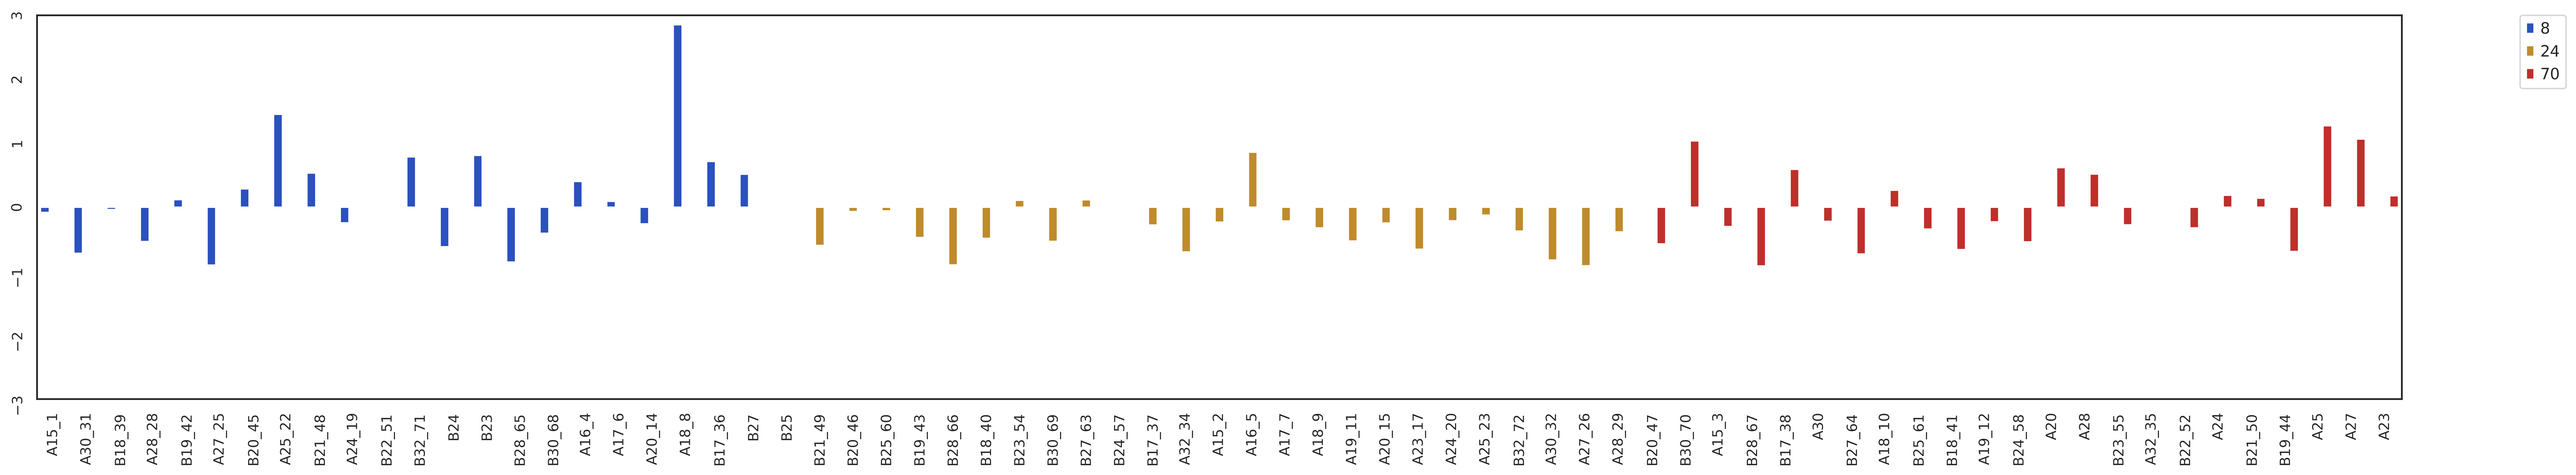

In [114]:
sns.set_style('white')
fig, axes = plt.subplots(figsize=(30,5))
axes.set_ylim([-3, 3])
axes.tick_params(labelsize=10,labelrotation=90)
sns.barplot(x=merged_gene_df_z_sum.index, y=0, hue='timepoint', data=merged_gene_df_z_sum, order=None, hue_order=[8,24,70],palette=color_map_timepoints)
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0)
axes.set_ylabel("")
axes.set_xlabel("")


# ELISA data

In [4]:
data_path = DATA_DIR + '/data_new/TW3-93_summary_ELISA.csv'

In [5]:
ELISA_data = pd.read_csv(data_path)
ELISA_data

,Experiment,ELISA,Day,Dose,Value,cell_line
0,TW3-93,26.10.21,1,0,2.024217,T3M4
1,TW3-93,26.10.21,1,2,2.239422,T3M4
2,TW3-93,26.10.21,1,10,1.803604,T3M4
3,TW3-93,26.10.21,1,20,3.032148,T3M4
4,TW3-93,26.10.21,1,40,5.292349,T3M4
...,...,...,...,...,...,...
252,TW3-93-3,18.11.2021,3,20,677.566106,BX-PC3
253,TW3-93-3,18.11.2021,5,20,2009.466170,BX-PC3
254,TW3-93-3,18.11.2021,1,40,163.023558,BX-PC3
255,TW3-93-3,18.11.2021,3,40,800.019101,BX-PC3


In [16]:
#aggregate
ELISA_data_agg = ELISA_data.drop(columns=['ELISA','Experiment']).groupby(['cell_line','Day','Dose',]).agg({'Value':['mean']})
ELISA_data_agg

Value
                          mean
cell_line Day Dose            
BX-PC3    1   0     280.849808
              2     251.944549
              10    222.160884
              20    287.216498
              40    282.626944
...                        ...
T3M4      5   0     168.529147
              2     112.551982
              10     25.938635
              20     40.065319
              40     36.124864

[90 rows x 1 columns]

In [18]:
ELISA_data_agg

Value
                          mean
cell_line Day Dose            
BX-PC3    1   0     280.849808
              2     251.944549
              10    222.160884
              20    287.216498
              40    282.626944
...                        ...
T3M4      5   0     168.529147
              2     112.551982
              10     25.938635
              20     40.065319
              40     36.124864

[90 rows x 1 columns]

In [36]:
#separate days
ELISA_data_agg_d5 = ELISA_data_agg.loc[(slice(None),5,slice(None)),:]
ELISA_data_agg_d3 = ELISA_data_agg.loc[(slice(None),3,slice(None)),:]
ELISA_data_agg_d1 = ELISA_data_agg.loc[(slice(None),1,slice(None)),:]

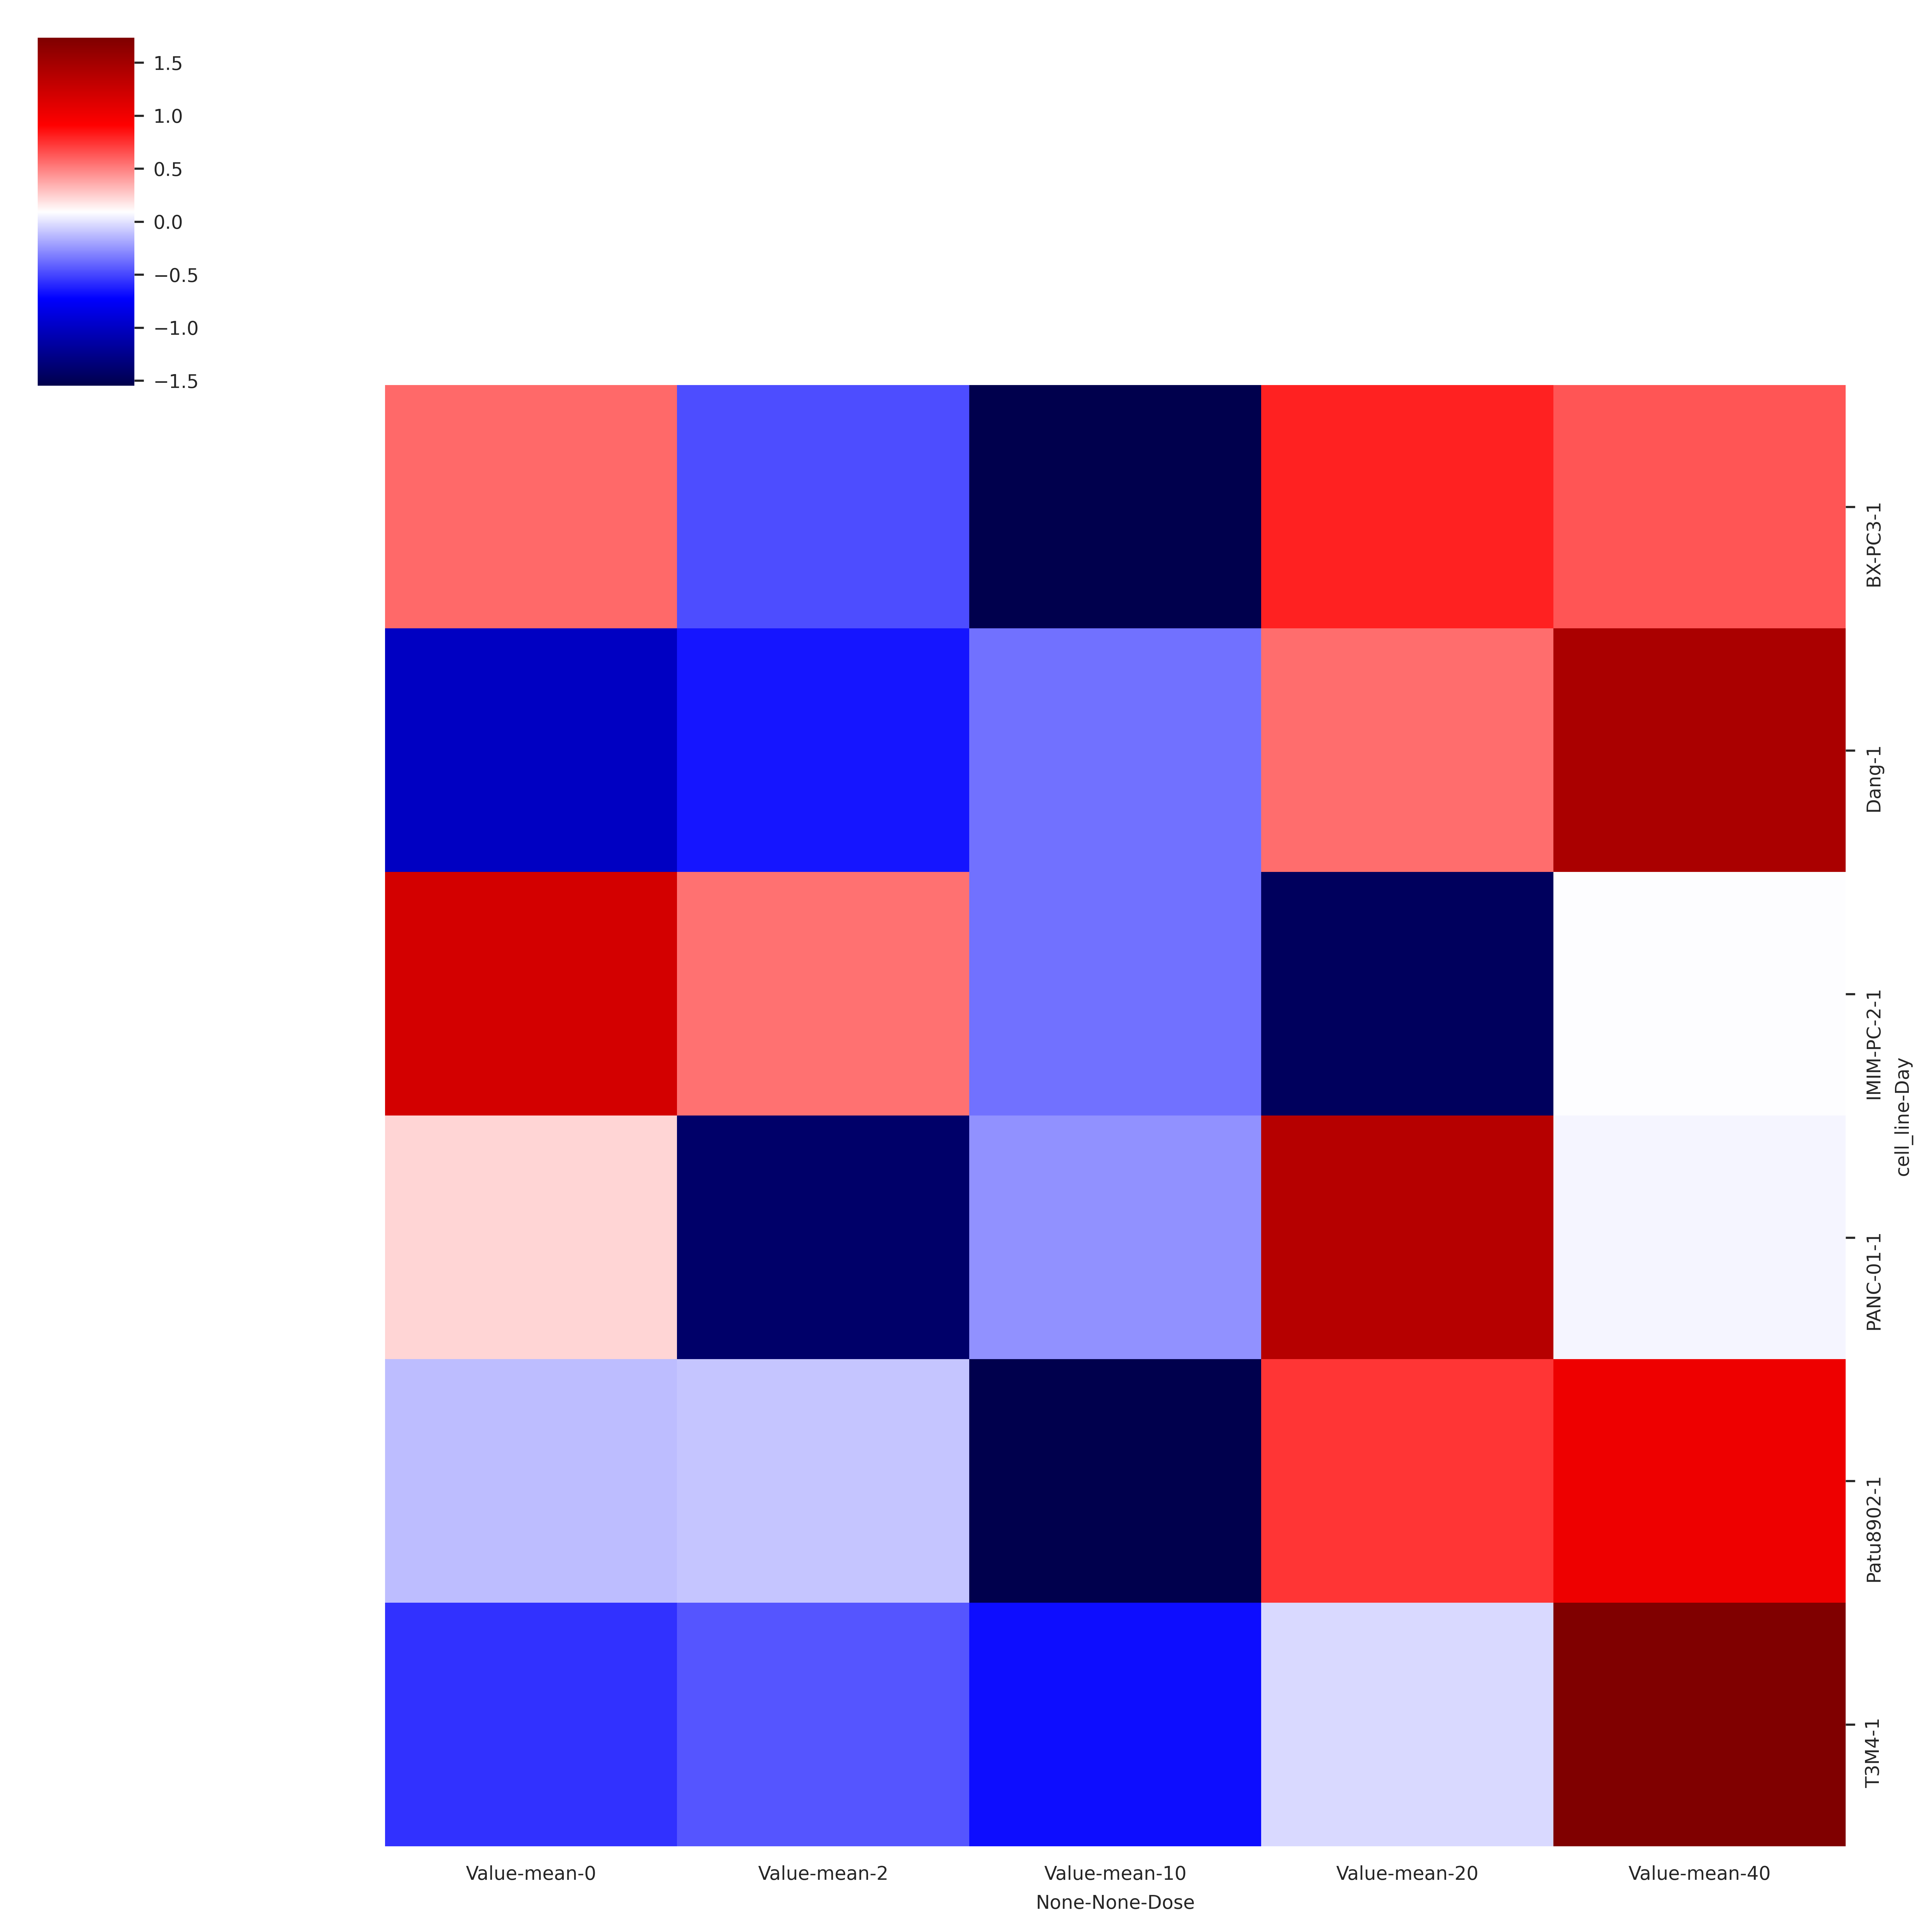

In [37]:
g = sns.clustermap(ELISA_data_agg_d1.unstack(), z_score=0,col_cluster=False, row_cluster=False, cmap='seismic')